In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### load data

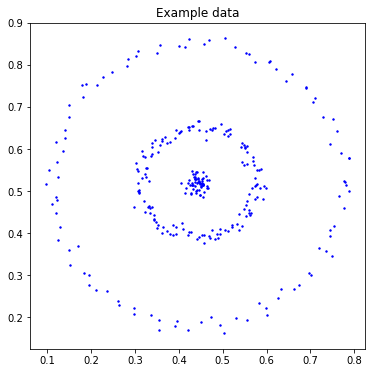

In [39]:
from scipy.io import loadmat

A = loadmat('Data2.mat')
n = len(A['data'])
p = len(A['data'][0])

for i in range(n):
    plt.scatter(A['data'][i][0],A['data'][i][1], s=2, c="blue")
plt.title("Example data")
plt.gcf().set_size_inches(6,6)
plt.show()

###  check the distribution of nearest neighbors

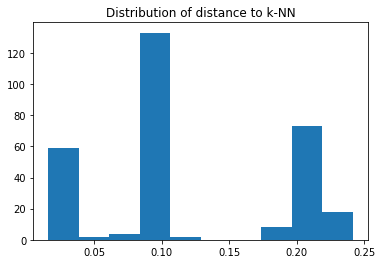

In [41]:
from scipy.spatial.distance import squareform, pdist

D = squareform(pdist(A['data']))

test_flag = 1
list1 = []

if test_flag:
    D_sort = sort(D,1)
    k=30
    
    for i in range(len(D_sort)):
        list1.append( D_sort[i][k+1] )    
    dist_knn = array(list1)
    list1.clear()
    
    median_val = median(dist_knn)
    eps_val = median_val*median_val/2
    sigmaK = sqrt(2)*median_val
    
    plt.hist(dist_knn)
    plt.title('Distribution of distance to k-NN')
    plt.gcf().set_size_inches(6,4)
    plt.show()

### set parameters in model

In [42]:
eps_val=0.05
neigen=10        #undifine=0
flag_t=0
if flag_t:
    t=3

### eigendecomposition

In [56]:
def diffuse(D,eps_val,neigen,t):
    
    n=len(D[0])
    
    K=get_K(D, eps_val)
    
    v=get_v(D, K)
    
    A=get_A(K, v)    #symmetric graph Laplacian
    
    [psi, phi, eigenvals]=get_psiphi(A)    #eigenvectors,eigenvalues of Markov matrix

    X = get_X(eigenvals, neigen, psi, t)    #non-trivial diffusion coords

    
    return X, eigenvals, psi, phi

In [44]:
def get_K(D, eps_val):
    list1=[]

    for i in range(n):
        for j in range(n):
            list1.append( exp(-D[i][j]*D[i][j]/(4*eps_val)) )
    K = array(list1).reshape(n, n)
    
    return K

In [45]:
def get_v(D, K):
    list1=[]
    
    for i in range(n):
        list1.append( sqrt(sum(K[i])) )
    v = array(list1).reshape(n,1)
    
    return v

In [46]:
from scipy.sparse import csr_matrix

def get_A(K, v):
    A = K/(v*v.T)
    threshold = 5e-6
    
    list1=[]
    list2=[]
    
    for i in range(n):
        for j in range(n):
            if A[i][j]>threshold:
                list1.append(1.)
            else: list1.append(0.)
    b = array(list1).reshape(n, n)
    
    A = csr_matrix(A*b, dtype=float)
    #AA = np.array(A)
    #A = A.T
    return A

In [47]:
from scipy.sparse.linalg import svds

def get_psiphi(A):
    list1=[]
    
    if neigen is 0:
        [U, S, V] = svds(A, 51)
        for i in range(n):
            for j in range(51):
                list1.append( U[i][0] )
        temp = array(list1).reshape(n, 51)
        psi = U/temp
        phi = U*temp
    else:
        [U, S, V] = svds(A, neigen+1)

        for i in range(n):
            for j in range(neigen+1):
                list1.append( U[i][0] )
        temp = array(list1).reshape(n, neigen+1)
        psi = U/temp
        phi = U*temp
        
    """
    print(U)
    print(len(psi),len(psi[0]))
    print(psi)
    print(phi)
    
    """

    S = flip(S)
    eigenvals = array(S).reshape(len(S), 1)
    
    return [psi, phi, eigenvals]

In [48]:
def get_X(eigenvals, neigen, psi, t):
    list1=[]
    list2=[]
    list3=[]
    list4=[]
    
    if t is 0:
        for i in range(n):
            for j in range(1, len(eigenvals)):
                list1.append( pow(eigenvals[j], t) )
        lambda_t = array(list1).reshape(n, len(eigenvals)-1)

        if neigen is 0:
            for i in range(len(eigenvals)):
                list2.append( lambda_t[0][i])/(lambda_t[0][0] )
            lam = array(list2)
            
            for i in range(len(eigenvals)):
                if lam[i]<0.05:
                    list3.append(lam[i])
            neigen = min(list3)
            neigen = min(neigen, 50)
        
        for i in range(n):
            for j in range(neigen):
                list4.append(psi[i][j+1]*lambda_t[i][j])
        X = array(list4).reshape(n, neigen)
    else:
        for i in range(n):
            for j in range(1, len(eigenvals)):
                list1.append( eigenvals[j]/(1-eigenvals[j]) )
        lambda_multi = array(list1).reshape(n, len(eigenvals)-1)
        
        if neigen is 0:
            for i in range(len(eigenvals)):
                list2.append( lambda_multi[0][i])/(lambda_t[0][0] )
            lam = array(list2)
            
            for i in range(len(eigenvals)):
                if lam[i]<0.05:
                    list3.append(lam[i])
            neigen = min(list3)
            neigen = min(neigen, 50)
        
        for i in range(n):
            for j in range(neigen):
                list4.append(psi[i][j+1]*lambda_multi[i][j])
        X = array(list4).reshape(n, neigen)
    
    return X

In [68]:
X, eigenvals, psi, phi = diffuse(D, eps_val, neigen, 1)

### fall-off of eigenvalues

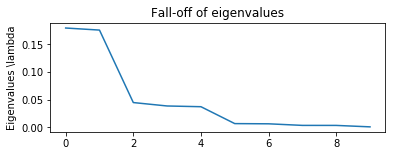

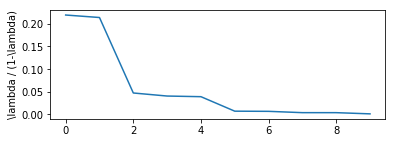

In [58]:
plt.plot(eigenvals[1:neigen+1])
plt.gcf().set_size_inches(6,2)
plt.ylabel('Eigenvalues \lambda')
plt.title('Fall-off of eigenvalues')
plt.show()

if flag_t:
    plt.plot(pow(eigenvals[1:neigen+1], t))
    plt.gcf().set_size_inches(6,2)
    plt.ylabel('\lambda^t')
    plt.show()
else:
    lambda_multi=eigenvals[1:neigen+1]/(1-eigenvals[1:neigen+1]) 
    plt.plot(lambda_multi)
    plt.gcf().set_size_inches(6,2)
    ylabel('\lambda / (1-\lambda)')
    plt.show()

### Diffusion map

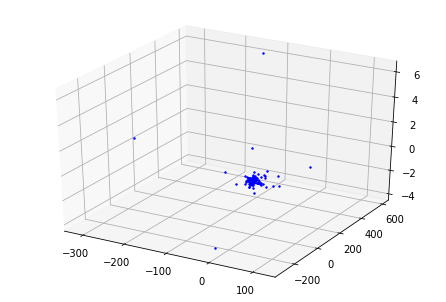

In [69]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
for i in range(len(X)):
    ax.scatter(X[i][0],X[i][1],X[i][2],s=2, c="blue")

### diffusion k-means

In [52]:
k=2
Niter=100

list1=[]
for i in range(n):
    list1.append(phi[i][0])
phi0=array(list1).reshape(n,1)

In [53]:
from math import ceil
import random as rnd

def diffusion_kmeans(X, k, phi0, Niter, epsilon):
    
    N=len(X)
    d=len(X[0])
    aD=Inf
    if epsilon is 0: epsilon=1e-3
    
    for i in range(1): #Niter
        tmp_ind = rnd.sample(range(N), k)
        
        list1=[]
        for p in tmp_ind:
            for q in range(d):
                list1.append(X[p][q])
        c_0 = array(list1).reshape(k, d)
        
    
        idx, c, cindex, D, DX = distortionMinimization(X, phi0, k, c_0, 0, epsilon)

        if D.all()<aD:
            aD=D
            aDX=DX
            a_idx=idx
            ac=c
    D=aD
    DX=aDX
    idx=a_idx
    C=ac
    
    return idx, C, D, DX

In [54]:
def distortionMinimization(X, phi0, k, c_0, DspFlag, epsilon):
    n=len(X)
    d=len(X[0])
    c=c_0
    oldD=Inf
    MaxIter=1000
    
    
    list1=[]
    list2=[]
    list3=[]
    
    for i in range(1): #MaxIter
        for j in range(k):
            for p in range(n):
                for q in range(d):
                    list1.append(X[p][q]-c[j][q])
            dX = (array(list1).reshape(n,d)).T #dX=dX.T
            list1.clear()
            
            list2.append(sum(dX.conj()*dX,axis=0))
        DX = (array(list2).reshape(k,n)).T
        list2.clear()
        
        for p in range(n):
            list1.append(min(DX[p]))
            list2.append(len(DX[p]))
        Dtmp = array(list1).reshape(1,n)
        S = array(list2).reshape(n,1)
        
        ind=0
        for p in range(k):
            if S[p]==p+1: ind=S[p]
            if ind==0:
                mx = max(Dtmp[0])
                m = argmax(Dtmp[0], axis=None)
                S[m][0] = p+1
                Dtmp[0][m] = 0
                
        for p in range(k):
            for q in range(d):
                c[p][q]=phi0[ind-1][0].T*X[ind-1][q]/sum(phi0[ind-1][0]) #??
                
        D = dot(phi0, Dtmp)
        
        for j in range(len(D)*len(D[0])):list3.append(Inf)
        oldD = array(list3).reshape(len(D), len(D[0]))
        
        list1.clear()
        list2.clear()
        list3.clear()
        
        if ((oldD-D)/D).all() < epsilon: break
        oldD=D
        
        
    for r in range(k):
        for p in range(n):
            for q in range(d):
                list1.append(X[p][q]-c[r][q])
        dX = (array(list1).reshape(n,d)).T #dX=dX.T
        list1.clear()
  
        list2.append(sum(dX.conj()*dX,axis=0))
        DX = array(list2).reshape(n,1)
        list2.clear()
            
        dummy = min(DX.T[0])
        list3.append( argmax(DX.T[0], axis=None) )
    cindex = array(list3).reshape(k,1)
        
    return S, c, cindex, D, DX

In [55]:
idx, C, ERR, DX = diffusion_kmeans(X, k, phi0, Niter, 0.001)

ValueError: setting an array element with a sequence.

### k-means labeling

In [38]:
for i in range(n):
    plt.scatter(A['data'][i][0],A['data'][i][1], s=2, marker=idx)

NameError: name 'idx' is not defined